# A3-HMM
#### By Emanuel Hernandez

## Load training data

In [1]:
import pandas as pd
from collections import Counter as ctr

In [2]:
#make a dataframe ignoring the last one from train.txt
train = pd.read_csv('train.txt', sep=' ', usecols=[0,1], names=['word','pos'] )
train['word'] = train.word.str.lower()
train.head(10)

,word,pos
0,confidence,NN
1,in,IN
2,the,DT
3,pound,NN
4,is,VBZ
5,widely,RB
6,expected,VBN
7,to,TO
8,take,VB
9,another,DT


## Clean data

In [3]:
train['ppos'] = train.pos.shift(1)
train['ppos'] = train['ppos'].fillna('O')
smooth = 0.000001
train.head()
#print(train[train['word'] == 'however'])

,word,pos,ppos
0,confidence,NN,O
1,in,IN,NN
2,the,DT,IN
3,pound,NN,DT
4,is,VBZ,NN


## Write the functions
$P(T{i}|T{i-1})$
$P(W{i}|T{i})$

In [4]:
# prev_pos contains a dict for every ppos in it... shows the amount of times each pos follows the ppos(key) 
#where every pos is also a key within ppos
prev_pos = {}
prev_pos_count = {} #count of how many times a ppos shows up
for pPos in set(train.ppos):
    temp_df = train[train.ppos == pPos] #dataframe with all instances of given ppos
    counted = ctr(temp_df.pos) #dict with counts for each pos following ppos
    prev_pos[pPos] = counted
    prev_pos_count[pPos] = len(temp_df)
    
def Ptt(Ti='',Tprev=''):
    if Ti not in prev_pos[Tprev]: return smooth
    return prev_pos[Tprev][Ti] / prev_pos_count[Tprev]

In [5]:
word_pos = {} #dict where every pos(key)'s value is the counted dict
word_pos_count = {} #dict with count of the times every pos is in train df
for pos in set(train['pos']):
    temp_df = train[train['pos'] == pos]
    counted = ctr(temp_df.word) #every word that belongs to pos with their # of ocurrences
    word_pos[pos] = counted
    word_pos_count[pos] = len(temp_df)

def Pwt(W='', T=''):
    if W not in word_pos[T]: return smooth
    return word_pos[T][W] / word_pos_count[T]

In [13]:
Pwt('pound','NN') #testing functions

0.00046439115003151226

## Load testing data

In [7]:
test = pd.read_csv('test.txt', sep=' ', usecols=[0,1], names=['word','pos'])
test['word'] = test['word'].str.lower()
test.head()

,word,pos
0,rockwell,NNP
1,international,NNP
2,corp.,NNP
3,'s,POS
4,tulsa,NNP


## Decode and test model

In [8]:
from operator import itemgetter
#sequence = ['this', 'is', 'not', 'the', 'time', 'for', 'surrender']
pos = list(set(train.pos))

max_tags = []
emission = [(t,Pwt(test.word[0], t)) for t in pos] #list of tuples where there first position is the pos and second is the P of the word given the pos
ptag = sorted(emission, key=itemgetter(1))[-1][0]
max_tags.append(ptag)

for word in test['word'][1:]:
    transition = [(ti,Ptt(ti,ptag)) for ti in pos] #list of tuple where the first position is the ppos and the second the P of pos given ppos
    emission = [(t,Pwt(word, t)) for t in pos]    
    clist = [(t[0],t[1]*e[1]) for t,e in zip(transition,emission)]
    ptag = sorted(clist, key=itemgetter(1))[-1][0]

    max_tags.append(ptag)

In [22]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test.pos, max_tags)

accuracy

0.9093653038394157

## Confusion Matrix

Text(0.5,0,'Predicted label\naccuracy=0.9094')

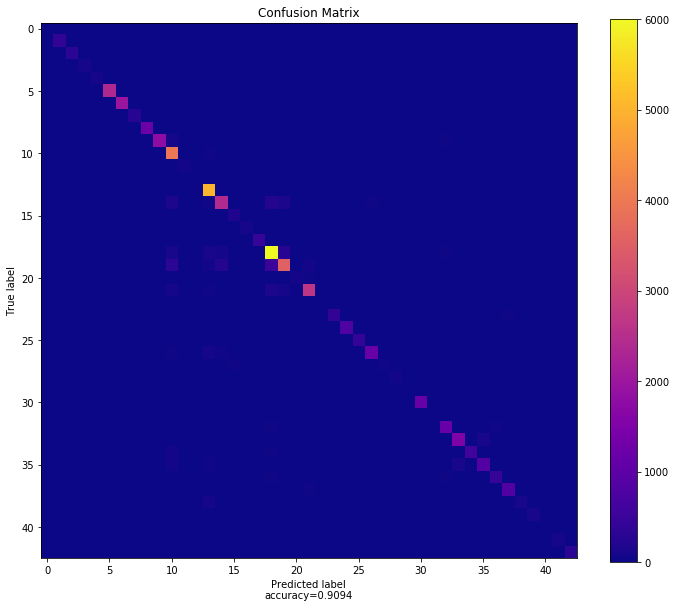

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

cmatrix = confusion_matrix(test.pos, max_tags)

plt.figure(figsize=(12, 10))
plt.imshow(cmatrix, cmap='plasma')
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(accuracy))

#### Given the confusion matrix, what are some common errors that your tagger makes?  

I feel it is hard to tell by a few reasons:  
- displaying the numbers in each box made the image pitch black
- I was not able to find a way to display the tags on the left and bottom axis
- it had a good accuracy score so not a lot of error to be seen

However, from the image, it can be seen the most error occured amongst the most popular tags such as NN and NNP.

### This is another method I found for visualizing a confusion matrix:

(I'm only showing the first 10 in the matrix to show what this method looks like)

In [25]:
y_true = pd.Series(test.pos)
y_pred = pd.Series(max_tags)
pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)[:10]

Predicted,#,$,'',(,),",",.,:,CC,CD,...,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``,All
True,,,,,,,,,,,,,,,,,,,,,
#,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
$,0,384,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,384
'',0,0,314,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,316
(,0,0,0,76,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,77
),0,0,0,0,77,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,77
",",0,0,0,0,0,2390,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2390
.,0,0,0,0,0,0,1975,0,0,0,...,0,0,0,0,0,0,0,0,0,1975
:,0,0,0,0,0,0,0,237,0,0,...,0,0,0,0,0,0,0,0,0,238
CC,0,0,0,0,0,0,0,0,1210,0,...,0,0,0,0,0,0,0,0,0,1214


In [23]:
from client.api.notebook import Notebook
ok = Notebook('a3.ok')
ok.auth(inline=True, force=True)

Assignment: A3 HMM
OK, version v1.13.11


Open the following URL:

https://okpy.org/client/login/

After logging in, copy the code from the web page and paste it into the box.
Then press the "Enter" key on your keyboard.

Paste your code here: ML4GQ6SnSLp1ITmZHLGLwGFW2eLdYc
Successfully logged in as emanuelhernandez@u.boisestate.edu


In [ ]:
ok.submit()

<IPython.core.display.Javascript object>